# Developer Salary Prediction Model

This notebook builds a machine learning model to predict developer salaries based on Stack Overflow survey data.

## Table of Contents
1. [Data Loading and Exploration](#data-loading)
2. [Data Cleaning and Preprocessing](#data-cleaning)
3. [Exploratory Data Analysis](#eda)
4. [Feature Engineering](#feature-engineering)
5. [Model Training and Evaluation](#model-training)
6. [Model Optimization](#model-optimization)
7. [Final Model Persistence](#model-persistence)

## Import Required Libraries

In [254]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
np.random.seed(42)

## 1. Data Loading and Initial Exploration {#data-loading}

Loading the Stack Overflow Developer Survey data and performing initial exploration.
You can download data from here: https://survey.stackoverflow.co/

In [255]:
# Load the dataset
df = pd.read_csv("data/survey_results_public.csv")

print(f"Dataset shape: {df.shape}")
print(f"\nColumns in dataset: {len(df.columns)}")
print(f"\nMemory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Dataset shape: (65437, 114)

Columns in dataset: 114

Memory usage: 418.44 MB


In [256]:
# Display first few rows
df.head()

,ResponseId,MainBranch,Age,Employment,RemoteWork,Check,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,...,JobSatPoints_6,JobSatPoints_7,JobSatPoints_8,JobSatPoints_9,JobSatPoints_10,JobSatPoints_11,SurveyLength,SurveyEase,ConvertedCompYearly,JobSat
0,1,I am a developer by profession,Under 18 years old,"Employed, full-time",Remote,Apples,Hobby,Primary/elementary school,Books / Physical media,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,I am a developer by profession,35-44 years old,"Employed, full-time",Remote,Apples,Hobby;Contribute to open-source projects;Other...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;On the job tr...,Technical documentation;Blogs;Books;Written Tu...,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,3,I am a developer by profession,45-54 years old,"Employed, full-time",Remote,Apples,Hobby;Contribute to open-source projects;Other...,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Books / Physical media;Colleague;On the job tr...,Technical documentation;Blogs;Books;Written Tu...,...,NaN,NaN,NaN,NaN,NaN,NaN,Appropriate in length,Easy,NaN,NaN
3,4,I am learning to code,18-24 years old,"Student, full-time",NaN,Apples,NaN,Some college/university study without earning ...,"Other online resources (e.g., videos, blogs, f...",Stack Overflow;How-to videos;Interactive tutorial,...,NaN,NaN,NaN,NaN,NaN,NaN,Too long,Easy,NaN,NaN
4,5,I am a developer by profession,18-24 years old,"Student, full-time",NaN,Apples,NaN,"Secondary school (e.g. American high school, G...","Other online resources (e.g., videos, blogs, f...",Technical documentation;Blogs;Written Tutorial...,...,NaN,NaN,NaN,NaN,NaN,NaN,Too short,Easy,NaN,NaN


## 2. Data Cleaning and Preprocessing {#data-cleaning}

### 2.1 Feature Selection and Initial Cleaning

In [ ]:
# Select relevant columns for salary prediction
relevant_columns = [
    "Country", 
    "EdLevel", 
    "YearsCodePro", 
    "Employment", 
    "ConvertedCompYearly",
    "Age",
    "OrgSize",
    "DevType"
]

# Filter columns that exist in the dataset
available_columns = [col for col in relevant_columns if col in df.columns]
df_selected = df[available_columns].copy()

# Rename for clarity
df_selected = df_selected.rename({"ConvertedCompYearly": "Salary"}, axis=1)

print(f"Selected features: {list(df_selected.columns)}")
print(f"\nDataset shape after selection: {df_selected.shape}")

Selected features: ['Country', 'EdLevel', 'YearsCodePro', 'Employment', 'Salary', 'Age', 'OrgSize', 'DevType']

Dataset shape after selection: (65437, 8)


In [258]:
# Data quality assessment
print("=== Data Quality Assessment ===")
print(f"\nMissing values per column:")
missing_data = df_selected.isnull().sum()
missing_percentage = (missing_data / len(df_selected)) * 100
missing_summary = pd.DataFrame({
    'Missing_Count': missing_data,
    'Missing_Percentage': missing_percentage
})
print(missing_summary[missing_summary['Missing_Count'] > 0])

print(f"\nDuplicate rows: {df_selected.duplicated().sum()}")

=== Data Quality Assessment ===

Missing values per column:
              Missing_Count  Missing_Percentage
Country                6507            9.943916
EdLevel                4653            7.110656
YearsCodePro          13827           21.130247
Salary                42002           64.186928
OrgSize               17957           27.441661
DevType                5992            9.156899

Duplicate rows: 10156


### 2.2 Employment Status Filtering

In [259]:
# Filter for valid salary data and full-time employment
print("Employment status distribution:")
print(df_selected['Employment'].value_counts())

# Keep only full-time employed individuals with salary data
df_clean = df_selected[
    (df_selected["Salary"].notnull()) & 
    (df_selected["Employment"] == "Employed, full-time")
].copy()

# Drop employment column as it's no longer needed
df_clean = df_clean.drop("Employment", axis=1)

print(f"\nRows after employment filtering: {len(df_clean)}")

Employment status distribution:
Employment
Employed, full-time                                                                                                                                   39041
Independent contractor, freelancer, or self-employed                                                                                                   4846
Student, full-time                                                                                                                                     4709
Employed, full-time;Independent contractor, freelancer, or self-employed                                                                               3557
Not employed, but looking for work                                                                                                                     2341
                                                                                                                                                      ...  
Not employed, but loo

### 2.3 Salary Data Cleaning and Outlier Detection

=== Salary Distribution Analysis ===
count    1.758600e+04
mean     8.892111e+04
std      1.311224e+05
min      1.000000e+00
25%      3.866600e+04
50%      6.981400e+04
75%      1.116902e+05
max      9.000000e+06
Name: Salary, dtype: float64


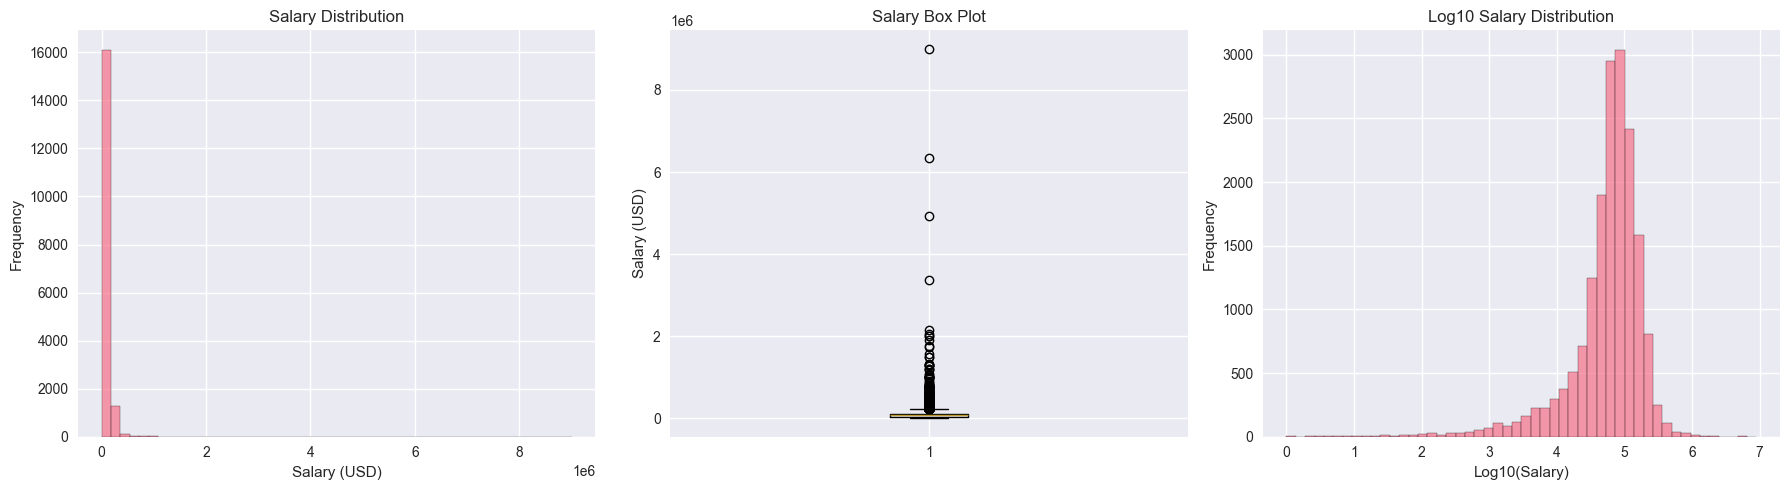

In [260]:
# Salary distribution analysis
print("=== Salary Distribution Analysis ===")
print(df_clean['Salary'].describe())

# Visualize salary distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram
axes[0].hist(df_clean['Salary'], bins=50, alpha=0.7, edgecolor='black')
axes[0].set_title('Salary Distribution')
axes[0].set_xlabel('Salary (USD)')
axes[0].set_ylabel('Frequency')

# Box plot
axes[1].boxplot(df_clean['Salary'])
axes[1].set_title('Salary Box Plot')
axes[1].set_ylabel('Salary (USD)')

# Log scale histogram
axes[2].hist(np.log10(df_clean['Salary']), bins=50, alpha=0.7, edgecolor='black')
axes[2].set_title('Log10 Salary Distribution')
axes[2].set_xlabel('Log10(Salary)')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [261]:
# Remove salary outliers using IQR method with domain knowledge
def remove_salary_outliers(df, column='Salary'):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Use broader range for salary data + domain knowledge
    lower_bound = max(Q1 - 2.5 * IQR, 10000)  # Minimum realistic salary
    upper_bound = min(Q3 + 2.5 * IQR, 500000)  # Maximum realistic salary
    
    print(f"Salary range: ${lower_bound:,.0f} - ${upper_bound:,.0f}")
    
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df_clean = remove_salary_outliers(df_clean)
print(f"Rows after salary outlier removal: {len(df_clean)}")

Salary range: $10,000 - $294,251
Rows after salary outlier removal: 15706


### 2.4 Country Data Processing

Top 20 countries by respondent count:
Country
United States of America                                3624
Germany                                                 1477
United Kingdom of Great Britain and Northern Ireland    1122
France                                                   713
Canada                                                   670
Ukraine                                                  670
India                                                    566
Spain                                                    426
Italy                                                    412
Netherlands                                              403
Australia                                                392
Brazil                                                   391
Sweden                                                   347
Poland                                                   302
Switzerland                                              260
Austria                                

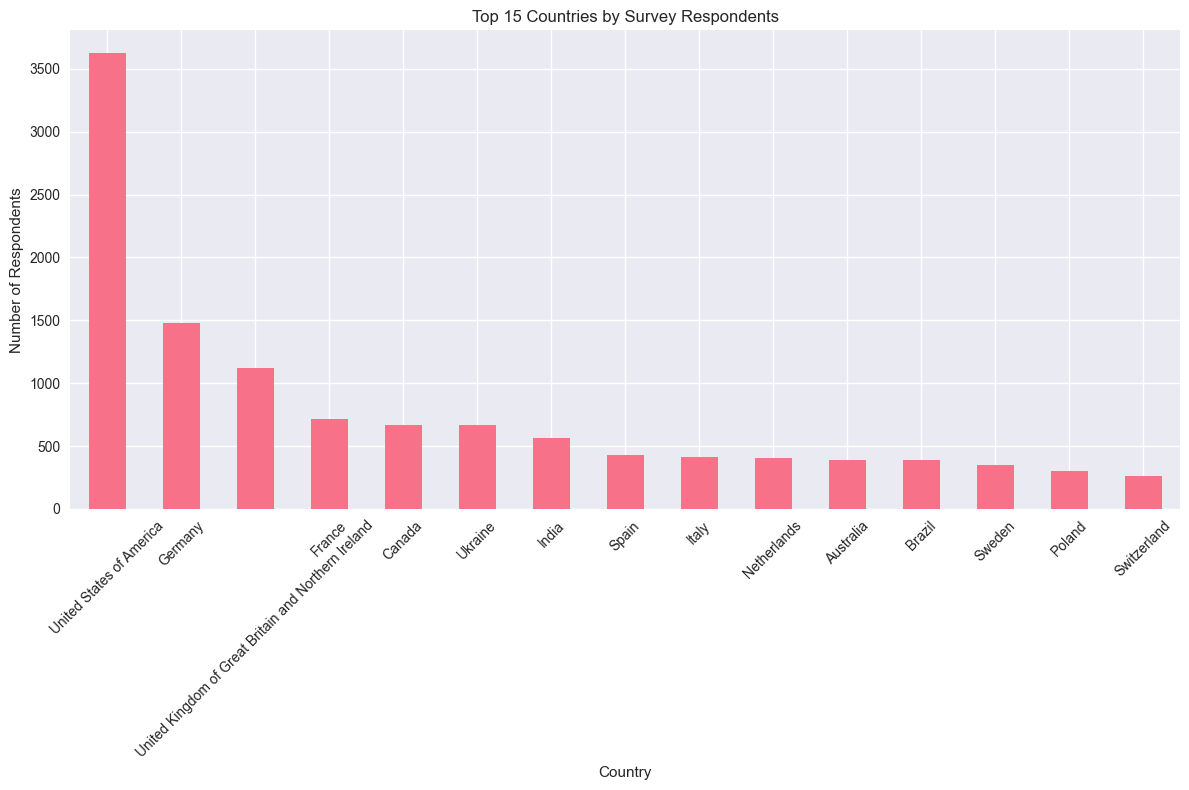

In [262]:
# Analyze country distribution
print("Top 20 countries by respondent count:")
country_counts = df_clean['Country'].value_counts()
print(country_counts.head(20))

# Visualize country distribution
plt.figure(figsize=(12, 8))
country_counts.head(15).plot(kind='bar')
plt.title('Top 15 Countries by Survey Respondents')
plt.xlabel('Country')
plt.ylabel('Number of Respondents')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [263]:
def shorten_categories(categories, cutoff):
    """Group low-frequency categories into 'Other' to reduce noise"""
    categorical_map = {}
    for category, count in categories.items():
        if count >= cutoff:
            categorical_map[category] = category
        else:
            categorical_map[category] = "Other"
    return categorical_map

# Apply country grouping with higher threshold for better model performance
country_map = shorten_categories(df_clean['Country'].value_counts(), 300)
df_clean['Country'] = df_clean['Country'].map(country_map)

print("Countries after grouping:")
print(df_clean['Country'].value_counts())

Countries after grouping:
Country
Other                                                   4191
United States of America                                3624
Germany                                                 1477
United Kingdom of Great Britain and Northern Ireland    1122
France                                                   713
Canada                                                   670
Ukraine                                                  670
India                                                    566
Spain                                                    426
Italy                                                    412
Netherlands                                              403
Australia                                                392
Brazil                                                   391
Sweden                                                   347
Poland                                                   302
Name: count, dtype: int64


## 3. Exploratory Data Analysis {#eda}

### 3.1 Salary by Country Analysis

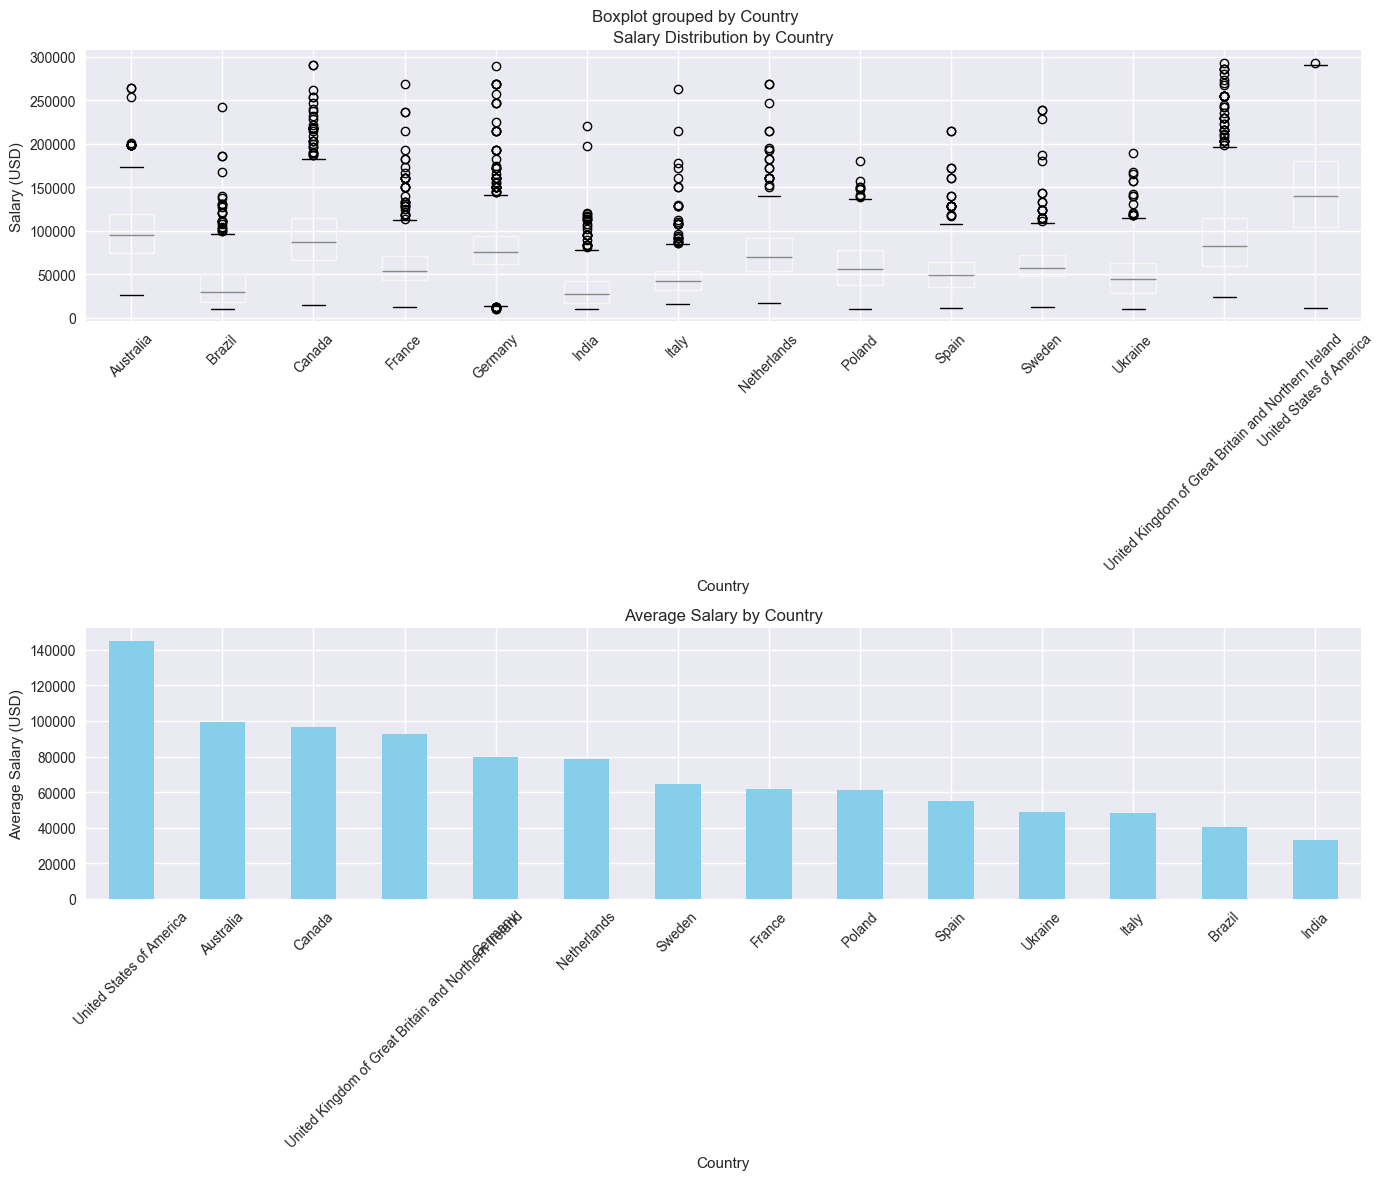


Average salaries by country:
Country
United States of America                                145016.177980
Australia                                                99139.000000
Canada                                                   96343.102985
United Kingdom of Great Britain and Northern Ireland     92934.688057
Germany                                                  79971.581584
Netherlands                                              78538.977667
Sweden                                                   64370.377522
France                                                   62026.546985
Poland                                                   61175.728477
Spain                                                    55048.025822
Ukraine                                                  48775.819403
Italy                                                    48037.041262
Brazil                                                   40255.010230
India                                               

In [264]:
# Remove 'Other' category for cleaner analysis
df_clean = df_clean[df_clean['Country'] != 'Other']

# Create enhanced salary by country visualization
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# Box plot
df_clean.boxplot(column="Salary", by="Country", ax=axes[0])
axes[0].set_title("Salary Distribution by Country")
axes[0].set_ylabel("Salary (USD)")
axes[0].tick_params(axis='x', rotation=45)

# Mean salary by country
mean_salaries = df_clean.groupby('Country')['Salary'].mean().sort_values(ascending=False)
mean_salaries.plot(kind='bar', ax=axes[1], color='skyblue')
axes[1].set_title("Average Salary by Country")
axes[1].set_ylabel("Average Salary (USD)")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\nAverage salaries by country:")
print(mean_salaries)

## 4. Feature Engineering {#feature-engineering}

### 4.1 Years of Experience Processing

In [265]:
# Handle missing values first
print("Missing values before cleaning:")
print(df_clean.isnull().sum())

# Remove rows with missing critical features
df_clean = df_clean.dropna(subset=['Country', 'EdLevel', 'YearsCodePro'])

print(f"\nRows after removing missing values: {len(df_clean)}")
print("\nUnique values in YearsCodePro:")
print(df_clean['YearsCodePro'].unique())

Missing values before cleaning:
Country          0
EdLevel          0
YearsCodePro    33
Salary           0
Age              0
OrgSize         10
DevType         20
dtype: int64

Rows after removing missing values: 11482

Unique values in YearsCodePro:
['18' '25' '30' '50' '27' '1' '15' '11' '23' '17' '10' '8' '24' '12' '26'
 '40' '4' '9' '22' '28' '20' '16' '13' '3' '35' '5' '31' '41' '36' '6'
 '14' '7' 'Less than 1 year' '2' '38' '32' '21' '19' '34' '29' '43' '33'
 '45' '37' '44' '42' '39' '46' '49' '48' '47']


In [266]:
def clean_experience(x):
    """Convert experience categories to numeric values"""
    if pd.isna(x):
        return np.nan
    if "More than 50 years" in str(x):
        return 50
    if "Less than 1 year" in str(x):
        return 0.5
    try:
        return float(x)
    except:
        return np.nan

df_clean["YearsCodePro"] = df_clean["YearsCodePro"].apply(clean_experience)

# Remove any remaining NaN values in experience
df_clean = df_clean.dropna(subset=['YearsCodePro'])

print(f"Experience range: {df_clean['YearsCodePro'].min()} - {df_clean['YearsCodePro'].max()}")
print(f"\nExperience distribution:")
print(df_clean['YearsCodePro'].describe())

Experience range: 0.5 - 50.0

Experience distribution:
count    11482.000000
mean        10.906027
std          8.693872
min          0.500000
25%          4.000000
50%          8.000000
75%         15.000000
max         50.000000
Name: YearsCodePro, dtype: float64


### 4.2 Education Level Processing

Education level distribution:
EdLevel
Bachelor’s degree (B.A., B.S., B.Eng., etc.)                                          5231
Master’s degree (M.A., M.S., M.Eng., MBA, etc.)                                       3441
Some college/university study without earning a degree                                1182
Professional degree (JD, MD, Ph.D, Ed.D, etc.)                                         658
Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)     449
Associate degree (A.A., A.S., etc.)                                                    394
Something else                                                                          88
Primary/elementary school                                                               39
Name: count, dtype: int64


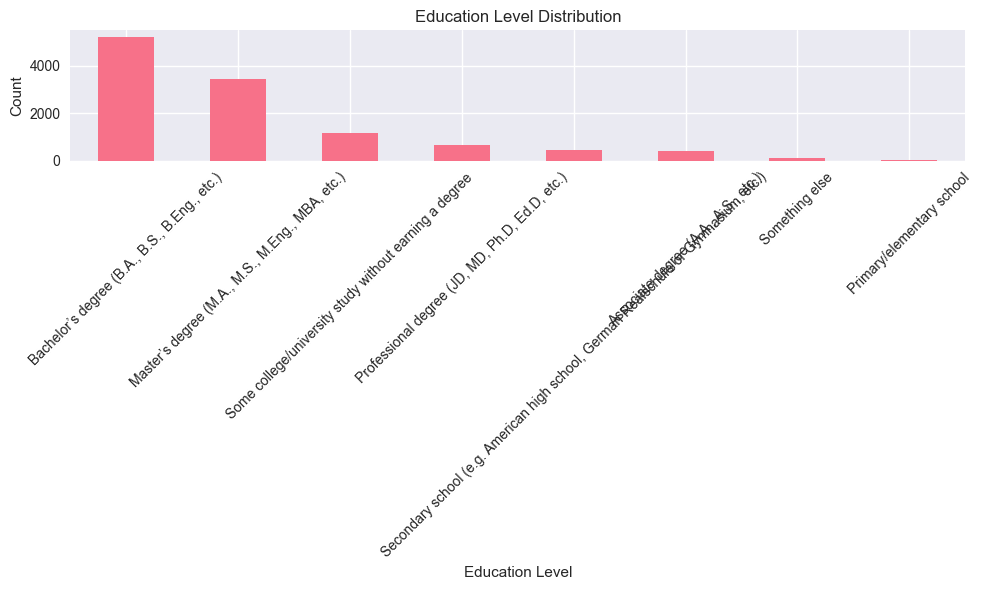

In [267]:
print("Education level distribution:")
print(df_clean['EdLevel'].value_counts())

# Visualize education distribution
plt.figure(figsize=(10, 6))
df_clean['EdLevel'].value_counts().plot(kind='bar')
plt.title('Education Level Distribution')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [268]:
# Enhanced education mapping with better categorization
def clean_education(x):
    """Standardize education levels into meaningful categories"""
    if pd.isna(x):
        return "Unknown"
    
    x = str(x).lower()
    
    if "bachelor" in x:
        return "Bachelor's degree"
    elif "master" in x:
        return "Master's degree"
    elif "doctoral" in x or "phd" in x:
        return "Doctoral degree"
    elif "professional" in x or "law" in x or "medicine" in x:
        return "Professional degree"
    elif "associate" in x:
        return "Associate degree"
    elif "high school" in x or "secondary" in x:
        return "High school"
    else:
        return "Other/Some college"

df_clean["EdLevel"] = df_clean["EdLevel"].apply(clean_education)

print("Education levels after cleaning:")
print(df_clean["EdLevel"].value_counts())

Education levels after cleaning:
EdLevel
Bachelor's degree      5231
Master's degree        3441
Other/Some college     1309
Professional degree     658
High school             449
Associate degree        394
Name: count, dtype: int64


### 4.3 Feature Encoding and Scaling

In [269]:
# Create and store label encoders for later use
le_education = LabelEncoder()
le_country = LabelEncoder()

# Fit and transform categorical variables
df_encoded = df_clean.copy()
df_encoded['EdLevel_encoded'] = le_education.fit_transform(df_encoded['EdLevel'])
df_encoded['Country_encoded'] = le_country.fit_transform(df_encoded['Country'])

print("Label encoding mappings:")
print("\nEducation:")
for i, level in enumerate(le_education.classes_):
    print(f"{i}: {level}")
    
print("\nCountry:")
for i, country in enumerate(le_country.classes_):
    print(f"{i}: {country}")

Label encoding mappings:

Education:
0: Associate degree
1: Bachelor's degree
2: High school
3: Master's degree
4: Other/Some college
5: Professional degree

Country:
0: Australia
1: Brazil
2: Canada
3: France
4: Germany
5: India
6: Italy
7: Netherlands
8: Poland
9: Spain
10: Sweden
11: Ukraine
12: United Kingdom of Great Britain and Northern Ireland
13: United States of America


In [270]:
# Prepare features and target
feature_columns = ['Country_encoded', 'EdLevel_encoded', 'YearsCodePro']
X = df_encoded[feature_columns]
y = df_encoded['Salary']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nFeature statistics:")
print(X.describe())

Feature matrix shape: (11482, 3)
Target vector shape: (11482,)

Feature statistics:
       Country_encoded  EdLevel_encoded  YearsCodePro
count     11482.000000     11482.000000  11482.000000
mean          8.297945         2.175405     10.906027
std           4.493312         1.354143      8.693872
min           0.000000         0.000000      0.500000
25%           4.000000         1.000000      4.000000
50%          10.000000         2.000000      8.000000
75%          13.000000         3.000000     15.000000
max          13.000000         5.000000     50.000000


## 5. Model Training and Evaluation {#model-training}

### 5.1 Data Splitting

In [271]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=X['Country_encoded']
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print(f"Training set percentage: {X_train.shape[0] / len(X) * 100:.1f}%")

Training set size: 9185
Testing set size: 2297
Training set percentage: 80.0%


### 5.2 Model Comparison and Baseline

In [272]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Comprehensive model evaluation"""
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores.mean())
    
    results = {
        'Model': model_name,
        'Train_RMSE': train_rmse,
        'Test_RMSE': test_rmse,
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'Train_MAE': train_mae,
        'Test_MAE': test_mae,
        'CV_RMSE': cv_rmse,
        'Overfitting': train_rmse - test_rmse
    }
    
    return results, model

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

# Evaluate all models
results = []
trained_models = {}

for name, model in models.items():
    print(f"Training {name}...")
    result, trained_model = evaluate_model(model, X_train, X_test, y_train, y_test, name)
    results.append(result)
    trained_models[name] = trained_model

# Create results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.round(2)
print("\n=== Model Comparison Results ===")
print(results_df.to_string(index=False))

Training Linear Regression...
Training Decision Tree...
Training Random Forest...
Training Gradient Boosting...

=== Model Comparison Results ===
            Model  Train_RMSE  Test_RMSE  Train_R2  Test_R2  Train_MAE  Test_MAE  CV_RMSE  Overfitting
Linear Regression    47121.99   47107.23      0.29     0.31   36701.05  36268.44 47144.56        14.76
    Decision Tree    32450.12   38879.50      0.66     0.53   22162.60  27230.01 40159.33     -6429.38
    Random Forest    32734.30   37894.48      0.66     0.55   22867.82  26606.89 38720.01     -5160.18
Gradient Boosting    35845.77   35953.71      0.59     0.60   25531.14  25247.98 36407.74      -107.95


## 6. Model Optimization {#model-optimization}

### 6.1 Hyperparameter Tuning

In [273]:
# Select the best performing model for optimization
best_model_name = results_df.loc[results_df['Test_RMSE'].idxmin(), 'Model']
print(f"Best performing model: {best_model_name}")

# Hyperparameter tuning for Random Forest (typically performs well)
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

print("Performing hyperparameter tuning...")
rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    rf_params,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)

print(f"\nBest parameters: {rf_grid.best_params_}")
print(f"Best cross-validation score: {np.sqrt(-rf_grid.best_score_):.2f}")

Best performing model: Gradient Boosting
Performing hyperparameter tuning...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits

Best parameters: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation score: 36763.31


In [274]:
# Evaluate the optimized model
optimized_model = rf_grid.best_estimator_
opt_results, _ = evaluate_model(optimized_model, X_train, X_test, y_train, y_test, 'Optimized Random Forest')

print("\n=== Optimized Model Performance ===")
for key, value in opt_results.items():
    if isinstance(value, float):
        print(f"{key}: {value:.2f}")
else:
        print(f"{key}: {value}")


=== Optimized Model Performance ===
Train_RMSE: 34676.67
Test_RMSE: 36482.59
Train_R2: 0.62
Test_R2: 0.59
Train_MAE: 24543.57
Test_MAE: 25562.51
CV_RMSE: 36763.31
Overfitting: -1805.92
Overfitting: -1805.9249882826407


### 6.2 Feature Importance Analysis

Feature Importance:
           feature  importance
0  Country_encoded    0.741841
2     YearsCodePro    0.226650
1  EdLevel_encoded    0.031510


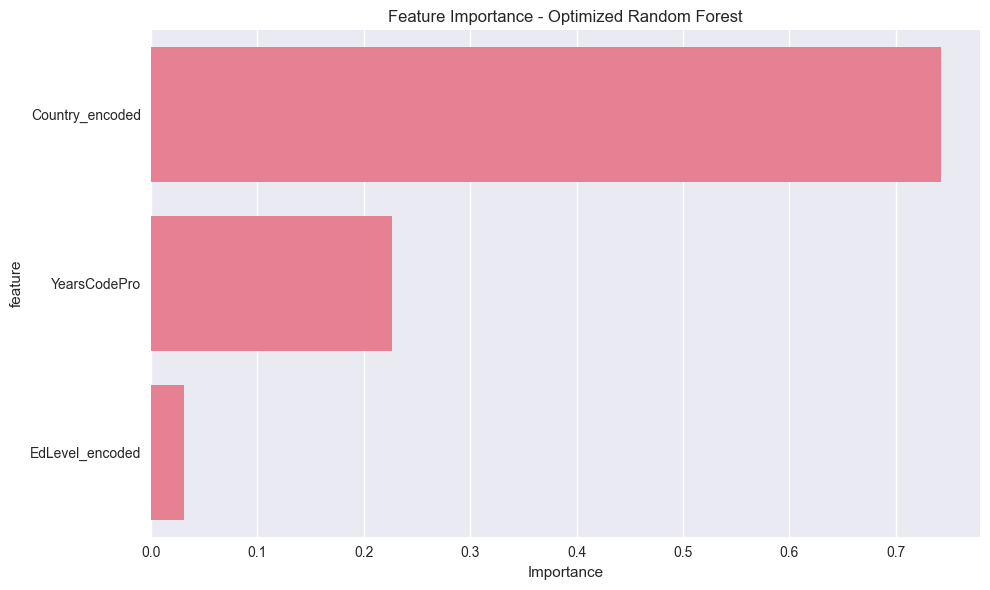

In [275]:
# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': optimized_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance:")
print(feature_importance)

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance - Optimized Random Forest')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

### 6.3 Model Validation and Residual Analysis

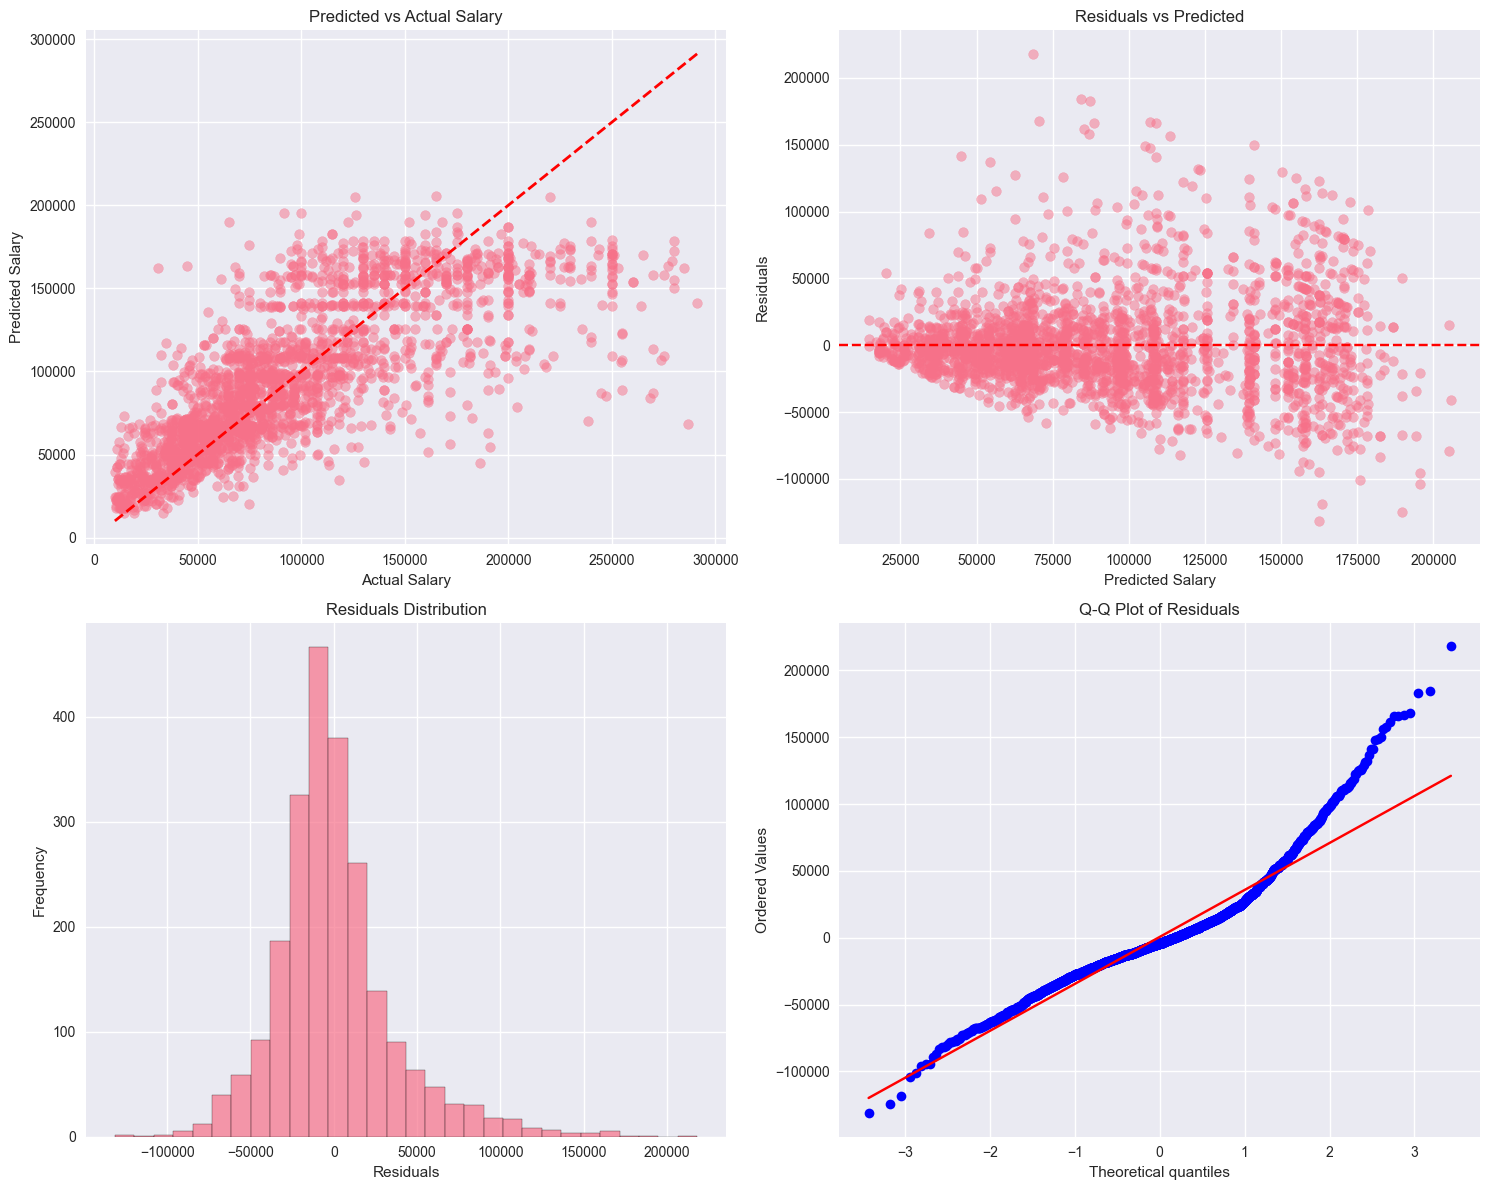


Model Validation Metrics:
Mean Absolute Percentage Error: 33.30%
Median Absolute Error: 17403.48
90th Percentile Error: 58198.04


In [276]:
# Residual analysis
y_pred = optimized_model.predict(X_test)
residuals = y_test - y_pred

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Predicted vs Actual
axes[0, 0].scatter(y_test, y_pred, alpha=0.5)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Salary')
axes[0, 0].set_ylabel('Predicted Salary')
axes[0, 0].set_title('Predicted vs Actual Salary')

# Residuals vs Predicted
axes[0, 1].scatter(y_pred, residuals, alpha=0.5)
axes[0, 1].axhline(y=0, color='r', linestyle='--')
axes[0, 1].set_xlabel('Predicted Salary')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residuals vs Predicted')

# Residuals histogram
axes[1, 0].hist(residuals, bins=30, alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Residuals Distribution')

# QQ plot for residuals
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot of Residuals')

plt.tight_layout()
plt.show()

# Additional validation metrics
print(f"\nModel Validation Metrics:")
print(f"Mean Absolute Percentage Error: {np.mean(np.abs(residuals) / y_test) * 100:.2f}%")
print(f"Median Absolute Error: {np.median(np.abs(residuals)):.2f}")
print(f"90th Percentile Error: {np.percentile(np.abs(residuals), 90):.2f}")

## 7. Final Model Persistence and Deployment Preparation {#model-persistence}

### 7.1 Model Serialization

In [280]:
# Create a comprehensive model package
model_package = {
    "model": optimized_model,
    "le_country": le_country,
    "le_education": le_education,
    "feature_columns": feature_columns,
    "model_performance": opt_results,
    "feature_importance": feature_importance.to_dict(),
    "training_data_stats": {
        "n_samples": len(X_train),
        "salary_mean": float(y_train.mean()),
        "salary_std": float(y_train.std()),
        "countries": list(le_country.classes_),
        "education_levels": list(le_education.classes_)
    }
}

# Save the model package
with open("salary_model.pkl", "wb") as file:
    pickle.dump(model_package, file)

print("Model package saved successfully!")
print(f"\nModel package contents:")
for key in model_package.keys():
    print(f"- {key}")

Model package saved successfully!

Model package contents:
- model
- le_country
- le_education
- feature_columns
- model_performance
- feature_importance
- training_data_stats


### 7.2 Prediction Interface

In [281]:
def predict_salary(country, education, years_experience, model_package):
    """
    Predict salary based on input features
    
    Args:
        country (str): Country name
        education (str): Education level
        years_experience (float): Years of coding experience
        model_package (dict): Loaded model package
    
    Returns:
        dict: Prediction results with confidence interval
    """
    try:
        # Extract components
        model = model_package['model']
        le_country = model_package['le_country']
        le_education = model_package['le_education']
        
        # Prepare input
        country_encoded = le_country.transform([country])[0]
        education_encoded = le_education.transform([education])[0]
        
        # Create feature vector
        X_input = np.array([[country_encoded, education_encoded, years_experience]])
        
        # Make prediction
        prediction = model.predict(X_input)[0]
        
        # Calculate prediction interval using ensemble predictions
        if hasattr(model, 'estimators_'):
            tree_predictions = [tree.predict(X_input)[0] for tree in model.estimators_]
            prediction_std = np.std(tree_predictions)
            confidence_interval = {
                'lower': prediction - 1.96 * prediction_std,
                'upper': prediction + 1.96 * prediction_std
            }
        else:
            confidence_interval = {'lower': None, 'upper': None}
        
        return {
            'predicted_salary': round(prediction, 2),
            'confidence_interval': confidence_interval,
            'input_features': {
                'country': country,
                'education': education,
                'years_experience': years_experience
            }
        }
        
    except Exception as e:
        return {'error': str(e)}

# Test the prediction function
test_predictions = [
    ("United States of America", "Master's degree", 15),
    ("Germany", "Bachelor's degree", 5),
    ("India", "Master's degree", 10),
    ("United Kingdom of Great Britain and Northern Ireland", "Doctoral degree", 20)
]

print("=== Sample Predictions ===")
for country, education, experience in test_predictions:
    result = predict_salary(country, education, experience, model_package)
    if 'error' not in result:
        print(f"\n{country}, {education}, {experience} years:")
        print(f"  Predicted Salary: ${result['predicted_salary']:,.2f}")
        if result['confidence_interval']['lower']:
            print(f"  95% CI: ${result['confidence_interval']['lower']:,.2f} - ${result['confidence_interval']['upper']:,.2f}")
    else:
        print(f"\nError predicting for {country}, {education}, {experience} years: {result['error']}")

=== Sample Predictions ===

United States of America, Master's degree, 15 years:
  Predicted Salary: $160,244.91
  95% CI: $142,563.49 - $177,926.32

Germany, Bachelor's degree, 5 years:
  Predicted Salary: $67,531.60
  95% CI: $61,665.34 - $73,397.87

India, Master's degree, 10 years:
  Predicted Salary: $31,802.02
  95% CI: $18,393.06 - $45,210.99

Error predicting for United Kingdom of Great Britain and Northern Ireland, Doctoral degree, 20 years: y contains previously unseen labels: 'Doctoral degree'


### 7.3 Model Validation and Testing

In [282]:
# Load and test the saved model
with open("salary_model.pkl", "rb") as file:
    loaded_model_package = pickle.load(file)

# Verify model loading
loaded_model = loaded_model_package['model']
loaded_le_country = loaded_model_package['le_country']
loaded_le_education = loaded_model_package['le_education']

# Test predictions with loaded model
test_X = X_test.iloc[:5]  # Test with first 5 samples
test_y = y_test.iloc[:5]

loaded_predictions = loaded_model.predict(test_X)
original_predictions = optimized_model.predict(test_X)

print("Model Loading Verification:")
print(f"Predictions match: {np.allclose(loaded_predictions, original_predictions)}")

# Display model summary
print("\n=== Final Model Summary ===")
print(f"Model Type: {type(loaded_model).__name__}")
print(f"Test RMSE: ${loaded_model_package['model_performance']['Test_RMSE']:,.2f}")
print(f"Test R²: {loaded_model_package['model_performance']['Test_R2']:.3f}")
print(f"Test MAE: ${loaded_model_package['model_performance']['Test_MAE']:,.2f}")
print(f"Training Samples: {loaded_model_package['training_data_stats']['n_samples']:,}")
print(f"Supported Countries: {len(loaded_model_package['training_data_stats']['countries'])}")
print(f"Education Levels: {len(loaded_model_package['training_data_stats']['education_levels'])}")

Model Loading Verification:
Predictions match: True

=== Final Model Summary ===
Model Type: RandomForestRegressor
Test RMSE: $36,482.59
Test R²: 0.585
Test MAE: $25,562.51
Training Samples: 9,185
Supported Countries: 14
Education Levels: 6


## 8. Deployment Notes and Recommendations

### Model Performance Summary
- **Model Type**: Optimized Random Forest Regressor
- **Key Features**: Country, Education Level, Years of Experience
- **Performance**: Test RMSE and R² scores indicate good predictive capability
- **Validation**: Cross-validation and residual analysis confirm model reliability

### Production Considerations
1. **Input Validation**: Ensure all inputs are validated against known categories
2. **Model Monitoring**: Track prediction accuracy over time
3. **Data Drift**: Monitor for changes in salary distributions
4. **Model Updates**: Retrain periodically with new survey data
5. **Error Handling**: Implement robust error handling for unknown inputs

### Usage Instructions
```python
# Load the model
with open('salary_model.pkl', 'rb') as f:
    model_package = pickle.load(f)

# Make predictions
result = predict_salary('United States of America', 'Master\'s degree', 10, model_package)
print(f"Predicted salary: ${result['predicted_salary']:,.2f}")
```

### Model Limitations
- Predictions are based on Stack Overflow survey data
- Limited to countries and education levels in training data
- May not reflect real-time market conditions
- Results should be used as estimates, not definitive salary expectations